# Compare the integral time scales from both the idealised and SUNTANS results

In [20]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map
from tqdm import tqdm

import sfoda.suntans.sunxarray as sxr
import pk2015_utils as utils
import speccy
import nonstat_itides_jax as nsjax
import nonstat_itides as nsit

In [21]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [22]:
def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)



In [23]:
# Load the suntans results
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

In [24]:
paramsfile = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_fD2D1_vc.nc'
scenario = 'seasonaltides_meso_fD2D1_vc'
units='cm s$^{-1}$'
vmax=5.
varname='vc'

In [25]:
ds_params = xr.open_dataset(paramsfile, engine='h5netcdf')
# ds_params = xr.open_dataset(paramsfile, engine='zarr')

# These need filling in??
ds_params.suntans.xv=ds_params.xv.values
ds_params.suntans.yv=ds_params.yv.values

ds_params

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:    (Nc: 225368, numsides: 8, params: 9, Nk: 80, time: 8761,
                Np: 454016)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r        (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells      (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    data       (Nc, params) float64 ...
    dv         (Nc) float64 ...
    dz         (Nk) float64 ...
    f_cpd_inv  (Nc) float32 ...
    nfaces     (Nc) int32 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6
    xp         (Np) float64 125.2 114.2 136.3 125.4 ... 117.0 117.0 117.1 117.1
    xv         (Nc) float64 109.0 109.1 109.1 109.2 ... 117.7 117.7 117.7 117.9
    yp         (Np) float64 -14.48 -22.48 -13.24 -14.54 ... -18.27 -18.27 -18.26
    yv         (Nc) float64 -19.4 -19.5 -19.61 -19.71 ... -13.1 -13.12 -13.07
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 None)

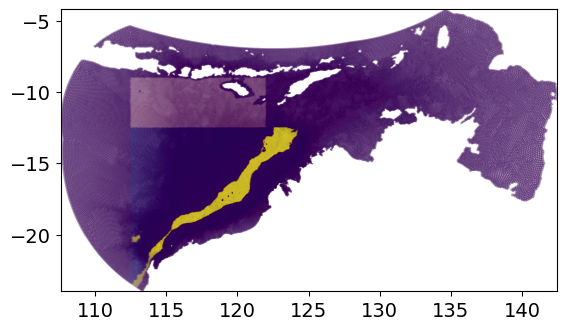

In [26]:
# Compute parameters in different regions

# Lower basin
regionA = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
    (ds_params.suntans.yv<-12.5) & (ds_params.dv>900)

# NWS
regionB = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
    (ds_params.suntans.yv<-12.5) & (ds_params.dv<900) & (ds_params.dv>200)

# Upper basin
# regionC = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
#     (ds_params.suntans.yv>-12.5) & (ds_params.suntans.yv<-8.0) & (ds_params.dv>900)

regionC = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<122.) &\
    (ds_params.suntans.yv>-12.5) & (ds_params.suntans.yv<-9.0) & (ds_params.dv>900)

ds_params.suntans.plotcelldata(regionA, alpha=0.1, cmap='RdBu',colorbar=False)
ds_params.suntans.plotcelldata(regionC, alpha=0.1, cmap='gist_ncar',colorbar=False)
ds_params.suntans.plotcelldata(regionB, alpha=0.1, colorbar=False)


In [27]:
tau_M = ds_params['data'].isel(params=1).values
gamma_M = ds_params['data'].isel(params=2).values
tau_D2 = ds_params['data'].isel(params=6).values

T_M = np.zeros_like(tau_M)
T_D2 = np.zeros_like(tau_M)

acf = nsjax.gamma_exp_1d

for ii in tqdm(range(T_M.shape[0])):
    T_M[ii] =  integral_timescale(acf, (1, tau_M[ii], gamma_M[ii]), tmax=500, N=1000)
    T_D2[ii] =  integral_timescale(acf, (1, tau_D2[ii], 1.5), tmax=500, N=1000)

100%|██████████| 225368/225368 [01:50<00:00, 2036.39it/s]


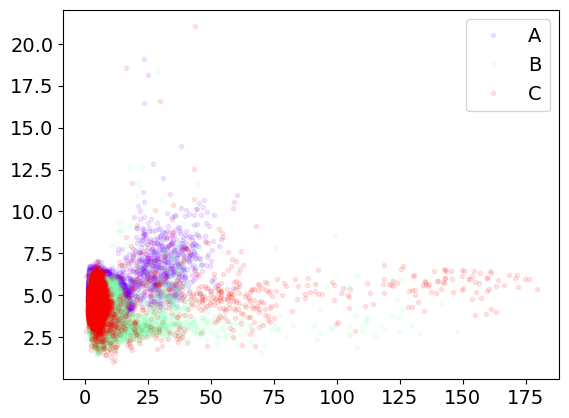

In [28]:
cmap = 'rainbow'
cmap = plt.colormaps.get_cmap(cmap)
colors = [cmap(ii) for ii in np.linspace(0,1,3)]

plt.figure()
plt.plot(T_M[regionA], T_D2[regionA], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB], T_D2[regionB], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC], T_D2[regionC], '.' , alpha=0.1, c=colors[2])
plt.legend(('A','B','C'))

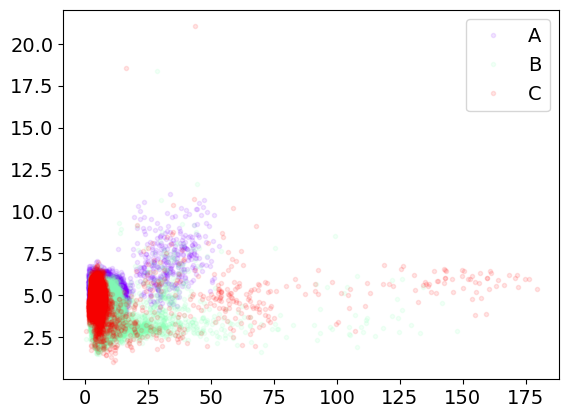

In [29]:
eta_M = ds_params['data'].isel(params=0).values
eta_D2 = ds_params['data'].isel(params=5).values

good = (eta_M>0.05) & (eta_D2>0.025)

plt.figure()
plt.plot(T_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

plt.legend(('A','B','C'))

Text(0.5, 0, '$T_m$')

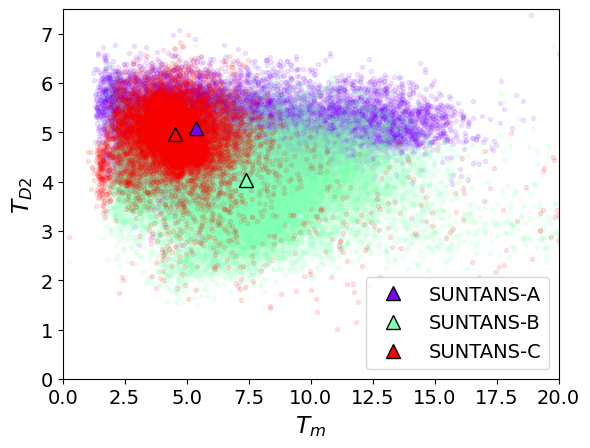

In [30]:
plt.figure()
ax=plt.subplot(111)
plt.plot(T_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(T_M[regionA & good]), np.median(T_D2[regionA & good]), '^' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(T_M[regionB & good]), np.median(T_D2[regionB & good]), '^' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(T_M[regionC & good]), np.median(T_D2[regionC & good]), '^' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend([p1,p2,p3],('SUNTANS-A','SUNTANS-B','SUNTANS-C'))
plt.ylim(0,7.5)
plt.xlim(0,20)
ax.set_ylabel('$T_{D2}$')
ax.set_xlabel('$T_m$')


Text(0.5, 0, '$L_m$')

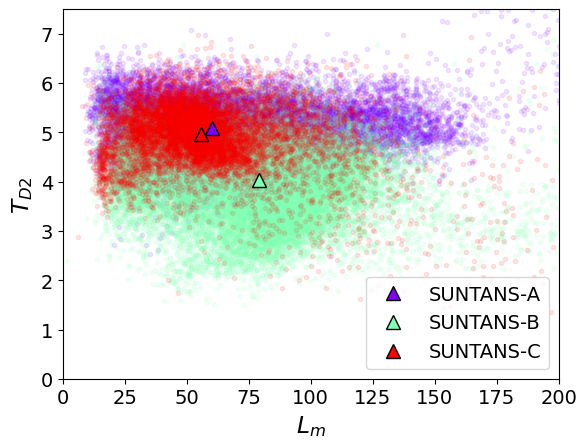

In [31]:
L_M = eta_M * T_M *86400 / 1000 # km


plt.figure()
ax=plt.subplot(111)
plt.plot(L_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(L_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(L_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(L_M[regionA & good]), np.median(T_D2[regionA & good]), '^' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(L_M[regionB & good]), np.median(T_D2[regionB & good]), '^' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(L_M[regionC & good]), np.median(T_D2[regionC & good]), '^' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend([p1,p2,p3],('SUNTANS-A','SUNTANS-B','SUNTANS-C'))
plt.ylim(0,7.5)
plt.xlim(0,200)
ax.set_ylabel('$T_{D2}$')
ax.set_xlabel('$L_m$')

# Load the idealised model data


In [32]:
limits = {
    'η_m':[0., 0.6],
    'τ_m':[0,20],
    'γ_m':[1,2.],
    'η_D2':[0, 0.2],
    'τ_D2':[0,15],
    'γ_D2':[1,2.],
}
scenarios = ['wp5','wp6','wp75','wp8','wp9']
scenario_names = ['KE1','KE2','KE2.5','KE3','KE4']

9.229236167141835 5.474102731679928
4.229912914866922 4.319362223545922
3.8001230036427005 2.5706575156664186
3.7579499282560507 2.2809086141842956
4.27636225791563 1.536284574155222


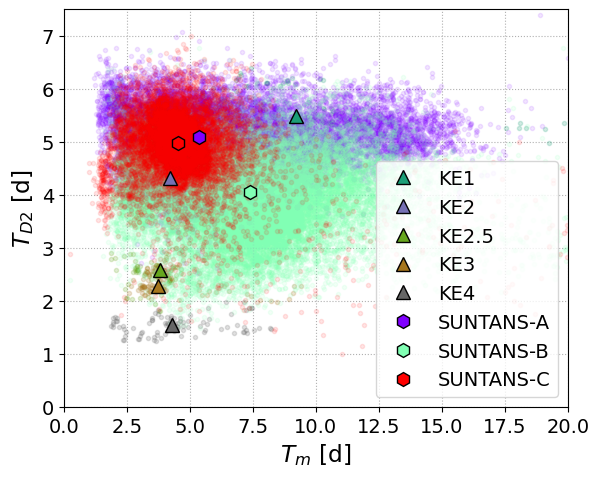

In [36]:
plt.figure(figsize=(6,5))
ax=plt.subplot(111)

acf = nsjax.gamma_exp_1d
covfunc = nsjax.itide_D2_meso_gammaexp
cmap = plt.colormaps.get_cmap('Dark2')
colors2 = [cmap(ii) for ii in np.linspace(0,1,5)]

p=[]
for cc, scenario in zip(colors2, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)
    data=ds['data'].values[-100:,:]
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T_meso = np.zeros((n,))
    T_it = np.zeros((n,))
    for ii in range(n):
        T_meso[ii] = integral_timescale(acf, data[ii,0:3])
        T_it[ii] = integral_timescale(acf, data[ii,3::])

    idx = ~np.isnan(T_meso)
    p1, = plt.plot(np.median(T_meso[idx]), np.median(T_it[idx]),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    plt.plot(T_meso, T_it,'.',c=cc, alpha=0.2)
    p.append(p1)

    print(np.median(T_meso[idx]), np.median(T_it[idx]))
#     #
#plt.legend(p, scenario_names)

# paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel('$T_{D2}$ [d]')
ax.set_xlabel('$T_m$ [d]')
ax.set_ylim(0,7.5)
#ax.set_xlim(0,250)
# ax.set_xlim(0, 15)

plt.grid(True, ls=':')
# plt.tight_layout()

plt.tight_layout()

# plt.figure()
# ax=plt.subplot(111)
plt.plot(T_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(T_M[regionA & good]), np.median(T_D2[regionA & good]), 'h' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(T_M[regionB & good]), np.median(T_D2[regionB & good]), 'h' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(T_M[regionC & good]), np.median(T_D2[regionC & good]), 'h' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend(p+[p1,p2,p3],scenario_names+['SUNTANS-A','SUNTANS-B','SUNTANS-C'])
plt.ylim(0,7.5)
plt.xlim(0,20)
# ax.set_ylabel('$T_{D2}$')
# ax.set_xlabel('$T_m$')
plt.savefig('../FIGURES/combined_T_vs_TD2.png', dpi=150)

## Key points

 - The median integral time scale for the mesoscale field was 4 - 9 d for both the realistic and idealised runs
 - Four of the idealised runs were 3 - 4 d (KE 1 was 9 d) and the two offshore realistic regions (A and C) were 4.5 and 5.5 d, respectively.
 - The shelf (region B) was anomalous lower T_D2 but higher T_M. 
 - Conclusion: eddy velocity scale eta_m was a more reliable indicator of the non-phase-locked internal tide timescale than the eddy timescale. The relationship to an eddy length scale was not tested.

